In [3]:
import ROOT
import ROOT.ROOT as rr

import uproot
import numpy as np
import pandas as pd
import os
from pathlib import Path
import awkward as ak
from matplotlib import pyplot as plt

import random

import FilterFunctions as ff
import cpp

Welcome to JupyROOT 6.24/00


### Implementation of the skimming step of the analysis

The skimming step reduces the inital generic samples to a dataset optimized for this specific analysis. Most important, the skimming removes all events from the initial dataset, which are not of interest for our study.

In [4]:
dirBasePath  = '/data/FCNC/'
dirOutPath = '/data/Skim/'
dirPlotPath = './Plots/'

listDir = os.listdir(dirBasePath)

In [5]:
def returnDir(string):
    return [filename for filename in listDir if filename.startswith(string)]

def loadData(chain, pathDirs, info=False):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    
    for Dir in pathDirs:
        if info: print('>>> Process directory ', Dir)
        file_list = os.listdir(dirBasePath + Dir)
        for file in file_list:
            chain.AddFile(dirBasePath + Dir + '/' + file)
            
    return chain

def CountEvents(df, info=True):
    n = df.Count().GetValue()
    if info: print('\nNumber of events:', n, '\n')
    return n

# Retrieve a histogram from the input file based on the process and the variable name
def getHistogram(tfile, name, variable, tag=''):
    name = '{}_{}{}'.format(name, variable, tag)
    h = tfile.Get(name)
    if not h:
        raise Exception('Failed to load histogram {}.'.format(name))
    return h

#### List of all MC background directories

'DYJetsToLL_M', 'QCD', 'ST_s', 'ST_t', 'ST_tW_antitop', 'ST_tW_top', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic',
'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu', 'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG',
'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu', 'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq'

In [4]:
# - Data + MC Signal
signalDirs = returnDir('SingleMuon')
signalMCDirs = returnDir('TT_FCNC')

# - MC backgrounds
listBkgDir = ['ST_', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic', 'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu',
              'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG', 'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu',
              'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq', 'QCD'] # DYJetsToLL_M

bkgMCDirs = dict(list(zip(listBkgDir, map(returnDir, listBkgDir))))
bkgMCChain = dict(list(zip(listBkgDir, [ROOT.TChain('Events') for _ in range(len(listBkgDir))])))

In [5]:
# - Load Data + MC Signal

chainSig = ROOT.TChain('Events')
dfData = rr.RDataFrame(loadData(chainSig, signalDirs))
#CountEvents(dfData)

chainMC = ROOT.TChain('Events')
dfMCSig = rr.RDataFrame(loadData(chainMC, signalMCDirs))
#CountEvents(dfMCSig)

In [6]:
# - Load MC backgrounds

dfMCBkg = {}
for key, value in bkgMCDirs.items():
    dfMCBkg[key] = rr.RDataFrame(loadData(bkgMCChain[key], value))
    #CountEvents(dfMCBkg[key])

### Read skimmed file

In [ ]:
%%bash

rm /data/Skim/*.root

In [7]:
%%bash

ls /data/Skim

In [8]:
for i in range(1,5): ff.DeclareVariables[i](dfData, 'Data', save=True)

In [9]:
for i in range(1,5): ff.DeclareVariables[i](dfMCSig, 'Signal', save=True)

In [10]:
for key, value in dfMCBkg.items():
    for i in range(1,5): ff.DeclareVariables[i](value, 'MC' + key, save=True)

### Histograms: save in `.root` extension

In [ ]:
ROOT.gROOT.SetBatch(True)

################################################################################
# Declare the range of the histogram for each variable
#
# Each entry in the dictionary contains of the variable name as key and a tuple
# specifying the histogram layout as value. The tuple sets the number of bins,
# the lower edge and the upper edge of the histogram.
################################################################################

# set w2 for MC errors - actually look for Sumw2() i.e. sum of weights squared!

# Book a histogram for a specific variable
def bookHistogram(df, variable, range_):
    return df.Histo1D(rr.RDF.TH1DModel(variable, variable, range_[0], range_[1], range_[2]), variable, 'eventWeightLumi')


# Write a histogram with a given name to the output ROOT file
def writeHistogram(h, name):
    h.SetName(name)
    h.Write()

################################################################################
# Main function of the histogramming step
#
# The function loops over the outputs from the skimming step and produces the
# required histograms for the final plotting.
################################################################################

def main(nSkim):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    ranges = ff.SkimRanges[nSkim]
    
    # Create output file
    tfile = ROOT.TFile(dirPlotPath + 'histogram_{}.root'.format(nSkim), 'RECREATE')
    variables = ranges.keys()
    
    fdfData = ff.DeclareVariables[nSkim](dfData, '', save=False)
    fdfMCSig = ff.DeclareVariables[nSkim](dfMCSig, '', save=False)
    
    # Loop through skimmed datasets and produce histograms of variables
    hists = {}
    for variable in variables:
        hists[variable] = bookHistogram(fdfData, variable, ranges[variable])

    hists_sig_mc = {}
    for variable in variables:
        hists_sig_mc[variable] = bookHistogram(fdfMCSig, variable, ranges[variable])

    # Write histograms to output file
    for variable in variables:
        writeHistogram(hists[variable], '{}_{}'.format('Data', variable))
    for variable in variables:
        writeHistogram(hists_sig_mc[variable], '{}_{}'.format('MCSig', variable))
        
    
    for key, value in dfMCBkg.items():
        fdfMCBkg = ff.DeclareVariables[nSkim](value, '', save=False)
        
        hists = {}
        for variable in variables:
            hists[variable] = bookHistogram(fdfMCBkg, variable, ranges[variable])
        for variable in variables:
            writeHistogram(hists[variable], '{}_{}'.format(key, variable))
    
    tfile.Close()

if __name__ == '__main__':
    main(4)

### Final plotting

In [54]:
################################################################################
# Implementation of the plotting step of the analysis
################################################################################

# Declare a human-readable label for each variable
nSkim = 3
labels = ff.SkimLabels[nSkim]
    
# Specify the color for each process:
# - Signal
colors = {
        'Data': ROOT.TColor.GetColor('#BF2229'),
        'MCSig': ROOT.TColor.GetColor('#00A88F'),
        }
# - MC BKG
colorsBkg = {
    'ST_': ROOT.TColor.GetColor(100, 192, 232),
    'TTTT_Tune': ROOT.TColor.GetColor(155, 152, 204),
    'TTToHadronic': ROOT.TColor.GetColor(155, 152, 204),
    'TTWJetsToLNu': ROOT.TColor.GetColor(155, 152, 204),
    'TTZToLLNuNu': ROOT.TColor.GetColor(155, 152, 204),
    'TTTo2L2Nu': ROOT.TColor.GetColor(248, 206, 104),
    'TTToSemiLeptonic': ROOT.TColor.GetColor(250, 202, 255),
    'WGToLNuG': ROOT.TColor.GetColor(222, 90, 106),
    'WJetsToLNu': ROOT.TColor.GetColor(222, 90, 106),
    'WWTo2L2Nu': ROOT.TColor.GetColor(222, 90, 106),
    'WWW': ROOT.TColor.GetColor(222, 90, 106),
    'WWZ': ROOT.TColor.GetColor(222, 90, 106),
    'WZG': ROOT.TColor.GetColor(222, 90, 106),
    'WZTo1L1Nu2Q': ROOT.TColor.GetColor(222, 90, 106),
    'WZTo2L2Q': ROOT.TColor.GetColor(222, 90, 106),
    'WZTo3LNu': ROOT.TColor.GetColor(222, 90, 106),
    'WZZ': ROOT.TColor.GetColor(222, 90, 106),
    'WmWmJJ': ROOT.TColor.GetColor(222, 90, 106),
    'WminusH': ROOT.TColor.GetColor(222, 90, 106),
    'WpWpJJ': ROOT.TColor.GetColor(222, 90, 106),
    'ZG': ROOT.TColor.GetColor(222, 90, 106),
    'ZZ': ROOT.TColor.GetColor(222, 90, 106),
    'tZq': ROOT.TColor.GetColor(6, 138, 43),
    # 'DYJetsToLL_M': ROOT.TColor.GetColor(100, 192, 232),
    'QCD': ROOT.TColor.GetColor(6, 138, 43),
}


################################################################################


# Main function of the plotting step
def plot_hist(variable, nSkim, mu=0):    
    tfile = ROOT.TFile(dirPlotPath + 'histogram_{}.root'.format(nSkim), 'READ')

    # Styles
    ROOT.gStyle.SetOptStat(0)

    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)

    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)

    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)

    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)

    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)

    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')

    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)

    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)

    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    legend = ROOT.TLegend(0.64, 0.70, 0.95, 0.91)
    legend.SetNColumns(2)

    # Data + MC
    data = getHistogram(tfile, 'Data', variable)
    MCSig = getHistogram(tfile, 'MCSig', variable)
    
    stack = ROOT.THStack('', '')
    seen, count, areaBkg, first = [], 0, 0, True
    titles = ['Single top', 't#bar{t}', 't#bar{t}#rightarrow l#nu l#nu', 't#bar{t}#rightarrow s-lep','Diboson', 'Others']
    for key, value in colorsBkg.items():
        histo = getHistogram(tfile, key, variable)
        histo.SetLineWidth(0)
        histo.SetFillColor(value)
        areaBkg += histo.Integral('width')
        stack.Add(histo)
        if first:
            bkgError = histo.Clone()
            first = False
        else:
            bkgError.Add(histo)
        if value not in seen:
            legend.AddEntry(histo, titles[count], 'f')
            count += 1
            seen.append(value)
    
    bkgError.SetFillStyle(3002)
    bkgError.SetFillColor(12)
    bkgError.SetMarkerSize(0)
    legend.AddEntry(bkgError, 'BKG err', 'f')
    
    if mu == 0:
        areaSig = MCSig.Integral('width')
        scale = areaBkg/areaSig
        MCSig.Scale(scale)
    else:
        MCSig.Scale(mu)
        MCSig.Add(bkgError)
        

    # Draw histograms
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
    MCSig.SetLineColor(colors['MCSig'])
    MCSig.SetLineWidth(3)

    c = ROOT.TCanvas('', '', 600, 600)
    
    name = data.GetTitle()
    if name in labels:
        title = labels[name]
    else:
        title = name


    stack.Draw('hist')
    bkgError.Draw('E2 SAME')
    MCSig.Draw('HIST SAME')
    data.Draw('E1P SAME')

    
    stack.GetXaxis().SetTitle(labels[variable])
    stack.GetYaxis().SetTitle('N_{Events}')
    stack.SetMaximum(max(bkgError.GetMaximum(), data.GetMaximum()) * 1.6)
    stack.SetMinimum(1.0)

    # Add legend
    legend.AddEntry(MCSig, 'FCNC', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    legend.Draw()

    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{CMS FCNC}')

    # Save
#     c.SaveAs(dirPlotPath + '{}_{}'.format(variable, nSkim))
    c.SaveAs(dirPlotPath + '{}_histogram_{}.png'.format(variable, nSkim))

# Loop over all variable names and make a plot for each
for variable in labels.keys():
    plot_hist(variable, nSkim, 0.019511718745343392)

Info in <TCanvas::Print>: png file ./Plots/Muon_pt15_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/lep_pt0_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/lep_pt1_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/lep_pt2_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/lep_eta0_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/lep_eta1_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/lep_eta2_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/inv_m01_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/inv_m12_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/inv_m02_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/inv_m3_histogram_3.png has been created
Info in <TCanvas::Print>: png file ./Plots/ST_histogram_3.png has been c

Jet_pt0_histogram_3.png



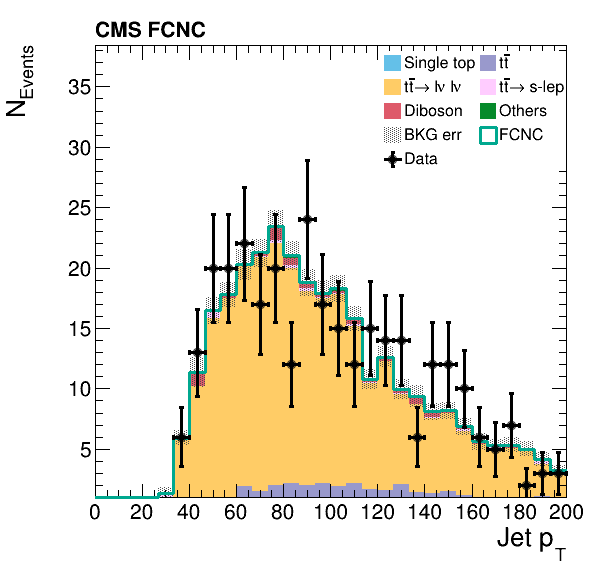

Jet_pt1_histogram_3.png



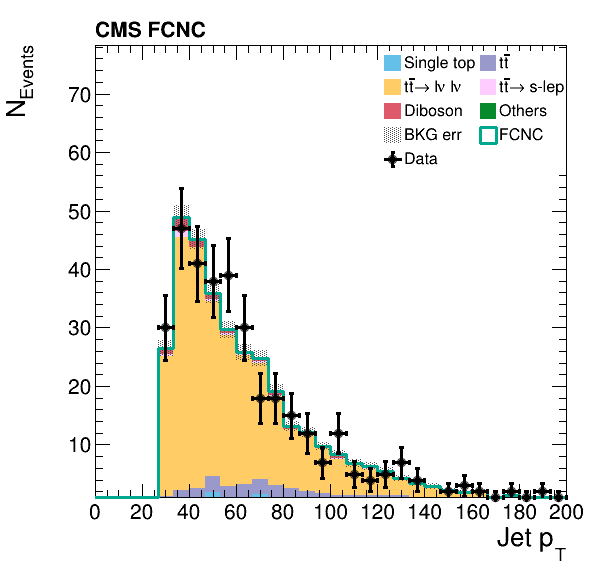

MET_pt_histogram_3.png



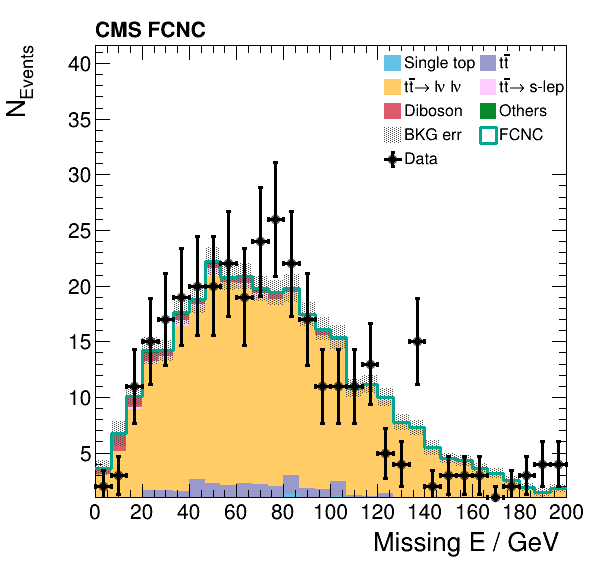

Muon_pt15_histogram_3.png



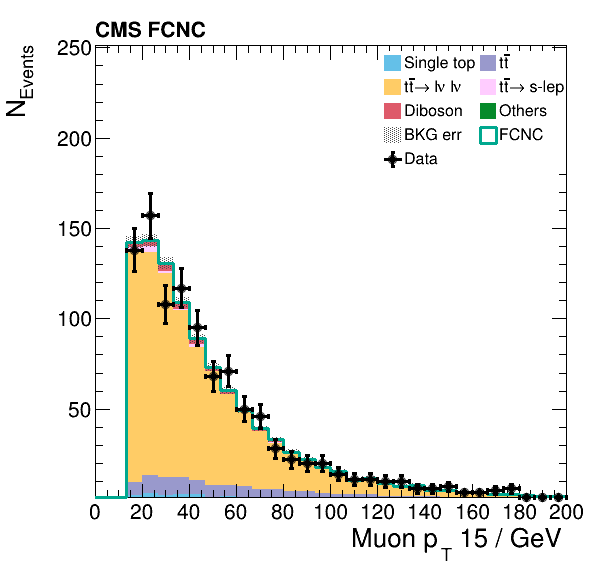

ST_histogram_3.png



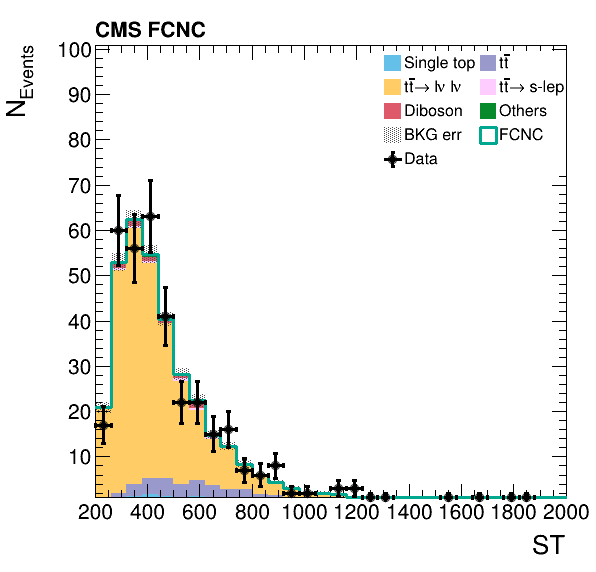

bJet_pt0_histogram_3.png



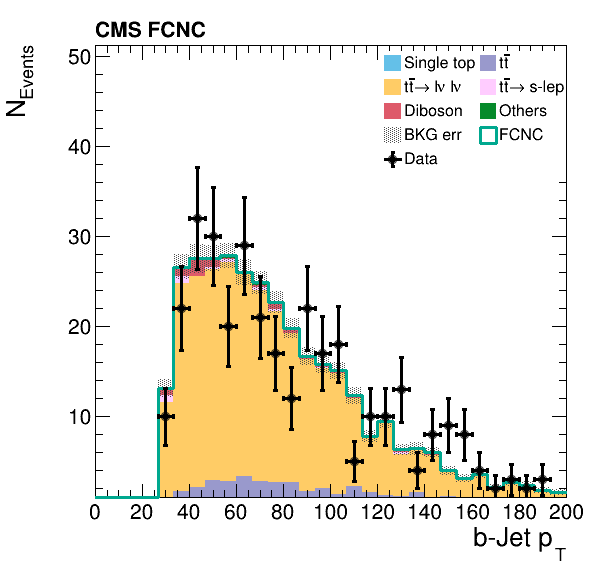

dPhi0_histogram_3.png



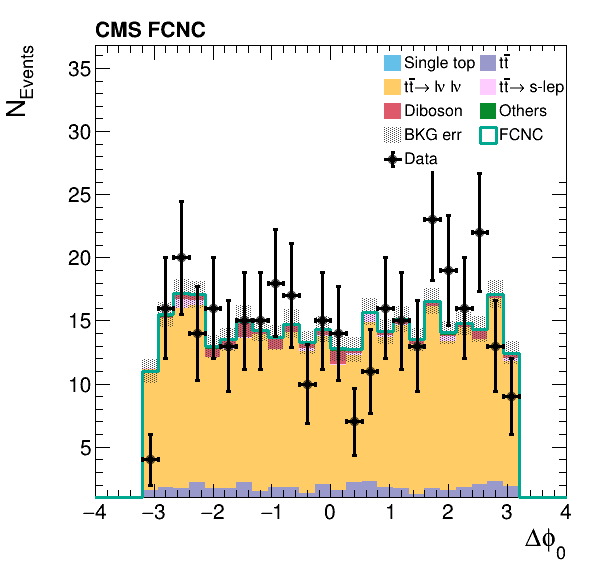

dPhi1_histogram_3.png



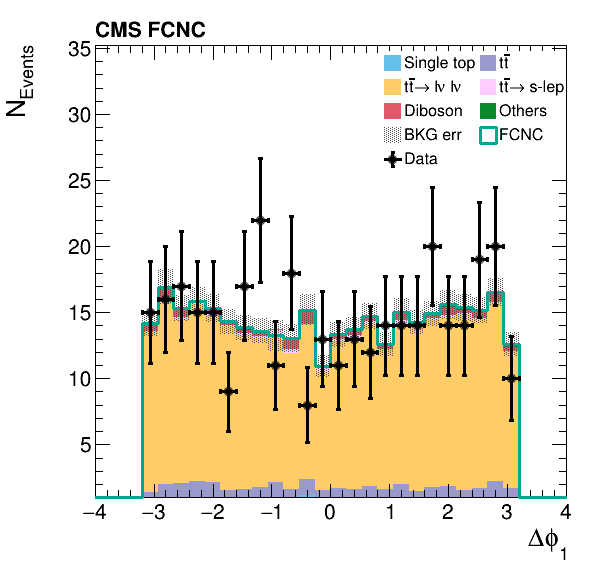

dPhi2_histogram_3.png



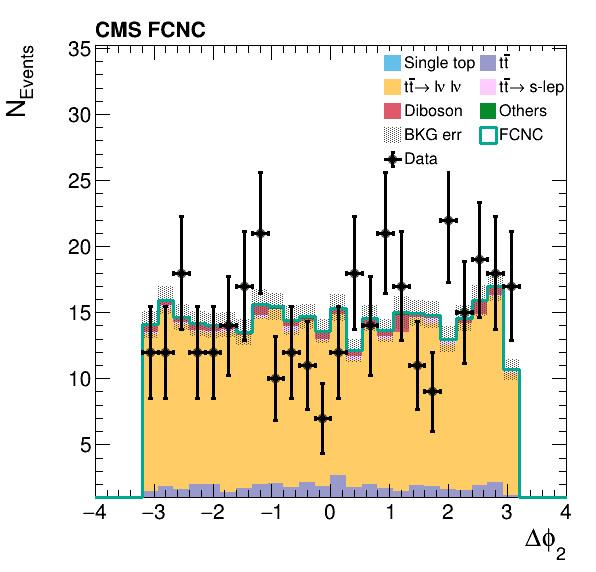

dR01_histogram_3.png



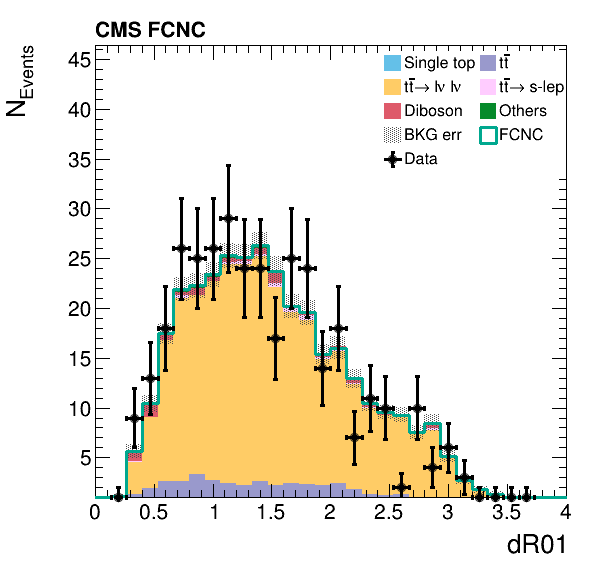

dR02_histogram_3.png



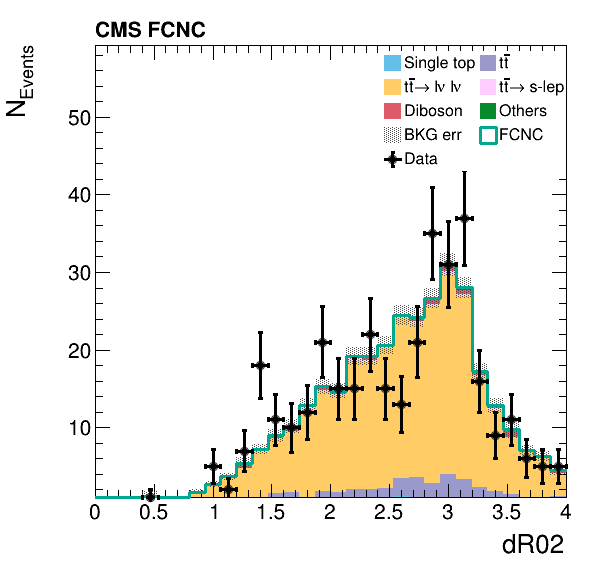

dR0bJ_histogram_3.png



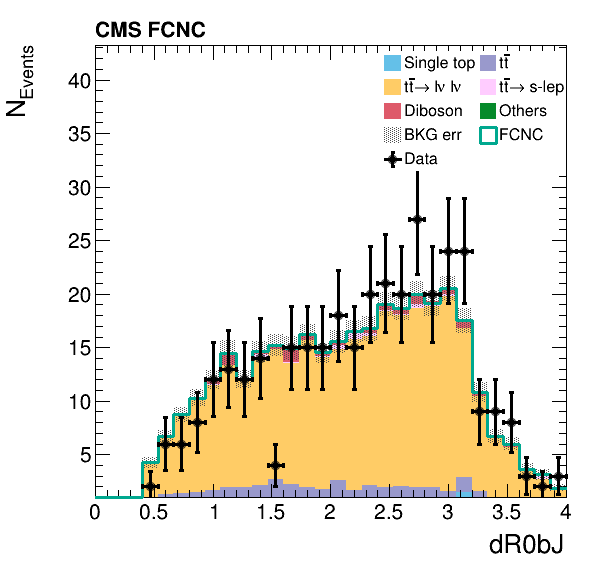

dR1J_histogram_3.png



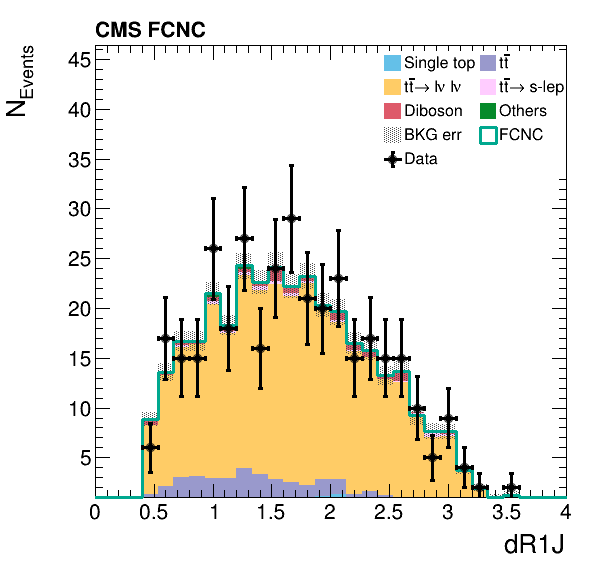

inv_m01_histogram_3.png



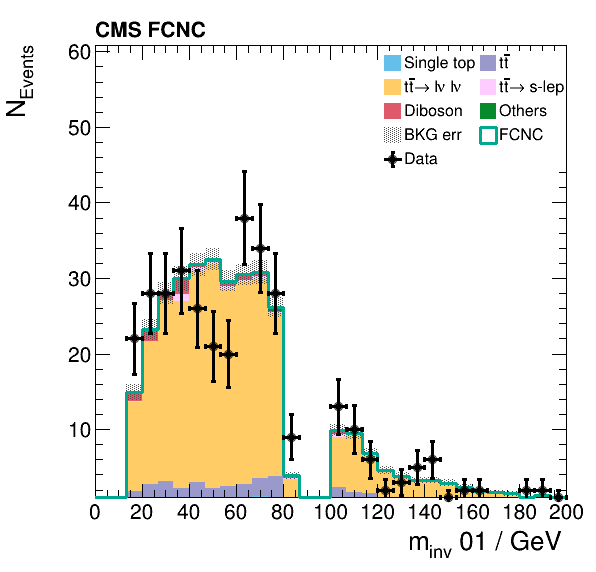

inv_m02_histogram_3.png



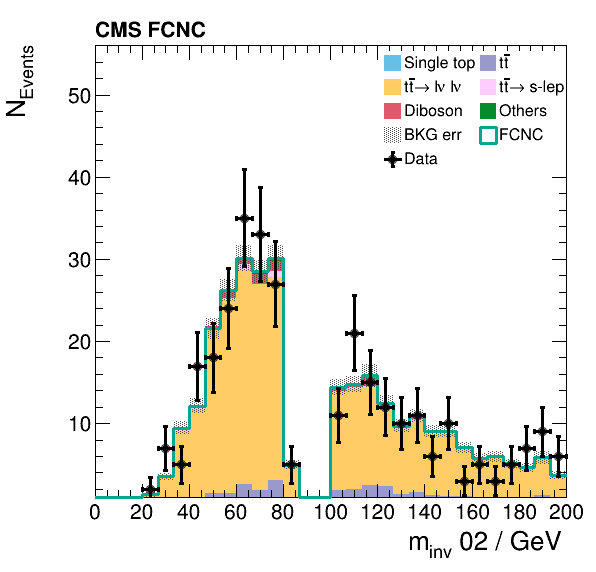

inv_m12_histogram_3.png



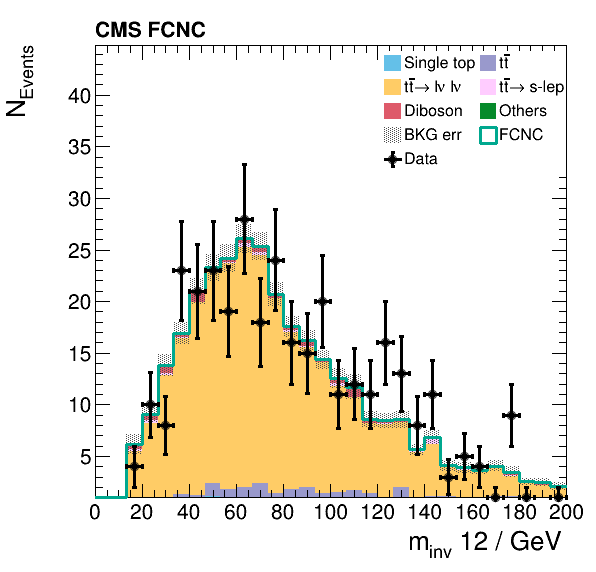

inv_m3_histogram_3.png



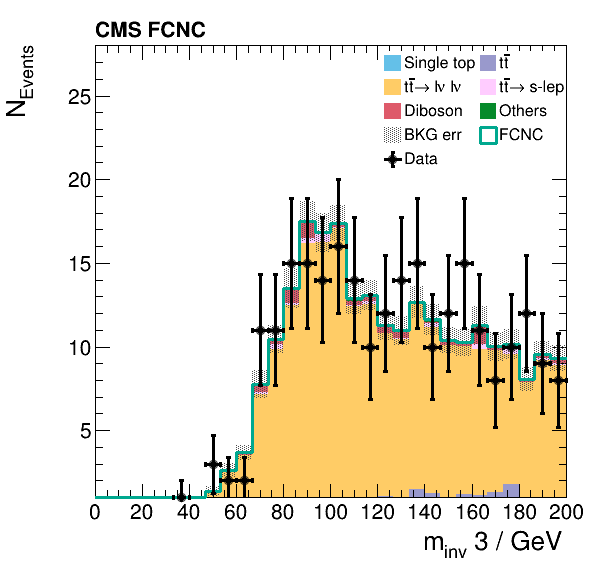

lep_eta0_histogram_3.png



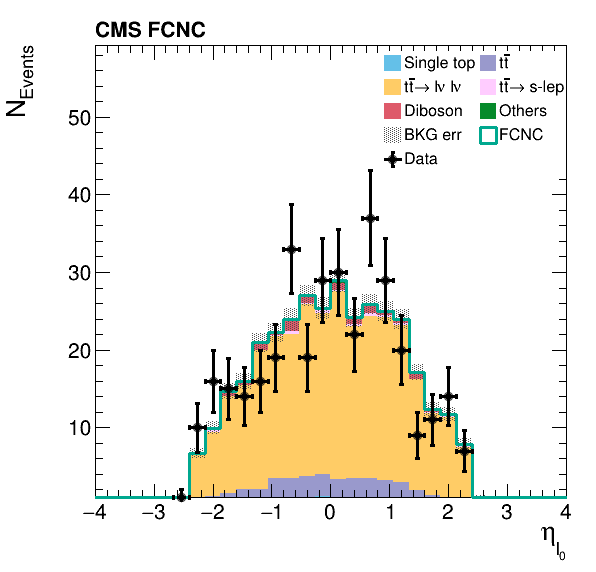

lep_eta1_histogram_3.png



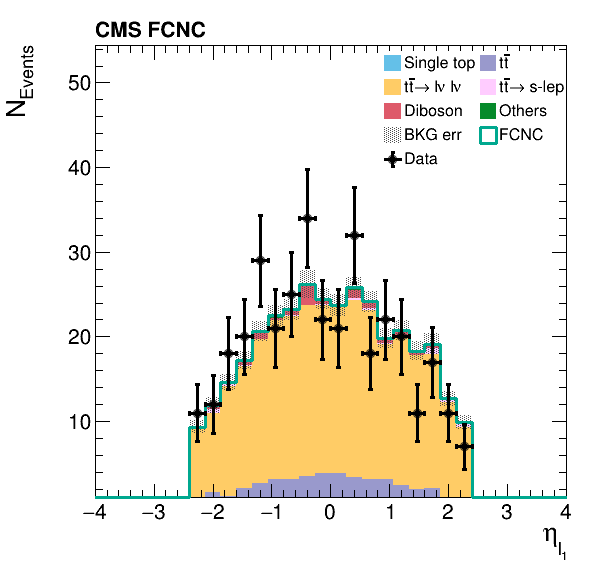

lep_eta2_histogram_3.png



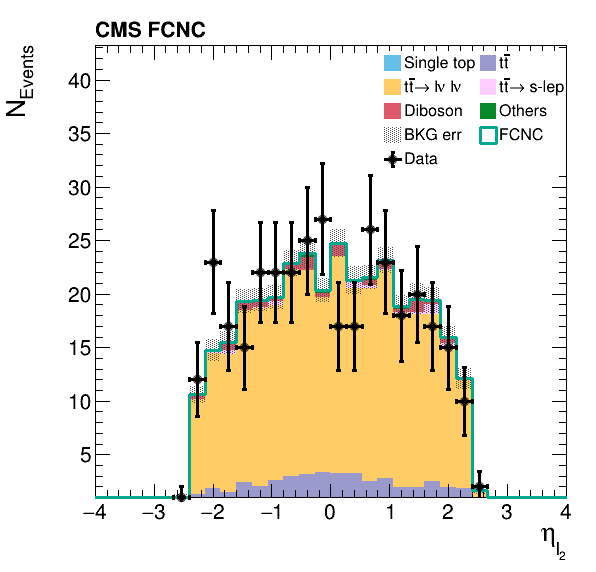

lep_pt0_histogram_3.png



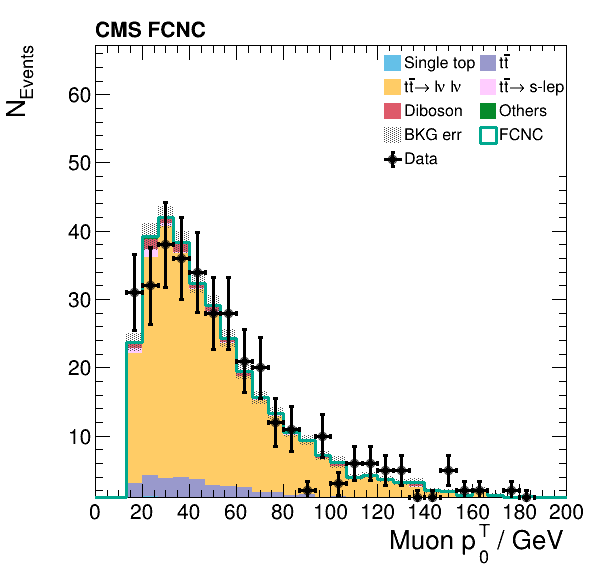

lep_pt1_histogram_3.png



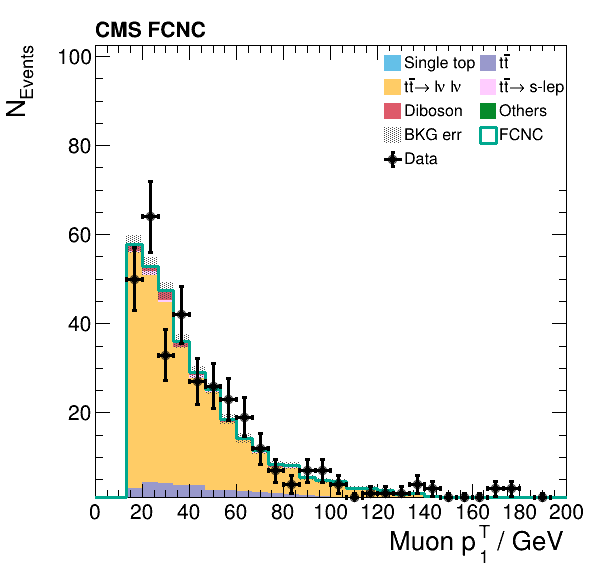

lep_pt2_histogram_3.png



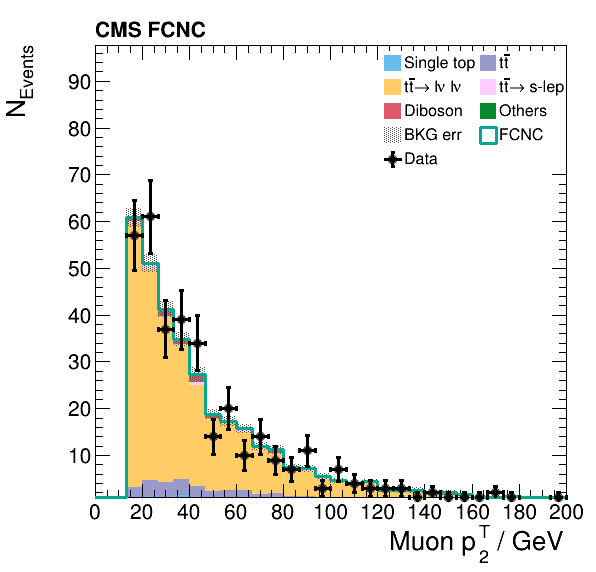

In [55]:
# ROOT.gROOT.GetListOfCanvases().Draw()
from IPython.display import Image
for image in sorted(os.listdir(dirPlotPath + '')):
    if image.endswith('histogram_3.png'):
        print(image + '\n')
        display(Image(filename=(dirPlotPath + '' + image)))

In [27]:
nSkim = 2
variable = 'lep_eta1'

def signif(nSkim, title, variable=variable):    
    tfile = ROOT.TFile(dirPlotPath + 'histogram_{}.root'.format(nSkim), 'READ')

    MCSig = getHistogram(tfile, 'MCSig', variable)
    
    stack = ROOT.THStack('', '')
    seen, count, areaBkg = [], 0, 0
    titles = ['Single top', 'top', 'tt#rightarrowW', 'tt#rightarrowZ','Diboson', 'Others']
    for key in dfMCBkg.keys():
        histo = getHistogram(tfile, key, variable)
        areaBkg += histo.Integral('width')
        
    areaSig = MCSig.Integral('width')
    significance = round(areaSig/np.sqrt(areaBkg),3)
    
    with open('signif.txt', 'a') as f:
        f.write('\niSkim' + str(nSkim) + '\t' + title + '\t' + str(significance))
        f.close()

In [ ]:
signif(2, '[lep_eta1]')

### Statistics

In [ ]:
def stat(files, variables):     # list of files .root, list of the same length of files with lists of variables
    
    import scipy as sp
    from scipy.stats import poisson as ps
    
    np.random.seed(12345)
    
    nbins, data, sig, bkg = 0, [], [], []
    
    for file,var in zip(files,variables):
        tfile = ROOT.TFile(dirPlotPath + 'Trials/' + file + '.root', 'READ')
        for v in var:
            data_hist = getHistogram(tfile, 'Data', v)
            sig_hist = getHistogram(tfile, 'MCSig', v)

            count = 0
            for key in dfMCBkg.keys():
                histo = getHistogram(tfile, key, v)
                if count == 0:
                    bkg_hist = histo
                    count += 1
                else:
                    bkg_hist.Add(histo)
            
            tmp_bins = data_hist.GetXaxis().GetNbins()
            data += [data_hist.GetBinContent(i) for i in range(1, tmp_bins+1)]
            sig += [sig_hist.GetBinContent(i) for i in range(1, tmp_bins+1)]
            bkg += [bkg_hist.GetBinContent(i) for i in range(1, tmp_bins+1)]
            nbins += tmp_bins
            
    data = np.array(data)
    sig = np.array(sig)
    bkg = np.array(bkg)
        
    mu_grid = np.arange(0, 3, 1e-3)
    
    b_plus_sig = np.outer(sig, mu_grid) + np.tile(bkg,(len(mu_grid),1)).T
    
    like_grid = np.prod(ps.pmf(np.tile(data,(len(mu_grid),1)).T, b_plus_sig), axis=0)
    mu_best = mu_grid[np.argmax(like_grid)]
    b_plus_sig_best = bkg + sig*mu_best
      
    ntoys = 1000000
    bin_toys = 1000
    
    mu_min = mu_best+1e-7
    mu_max = mu_best+1
    #mus = mu_best+np.arange(1e-7,2,0.1)
    #CL = []
    #significance = []
    for i in range(5):
        mu = (mu_min+mu_max)/2
        
        b_plus_sig_mu = bkg + sig*mu
        toys = ps.rvs(np.tile(b_plus_sig_mu,(ntoys,1)).T, size=(nbins,ntoys))
        
        like_num0 = np.sum(np.log(ps.pmf(toys, np.tile(bkg,(ntoys,1)).T)), axis=0)
        like_num1 = np.sum(np.log(ps.pmf(toys, np.tile(b_plus_sig_mu,(ntoys,1)).T)), axis=0)
        like_den = np.sum(np.log(ps.pmf(toys, np.tile(b_plus_sig_best,(ntoys,1)).T)), axis=0)
    
        q_mu0 = -2 * (like_num0 - like_den)
        q_mu1 = -2 * (like_num1 - like_den)
        
        like_num_obs = np.prod(ps.pmf(data, b_plus_sig_mu))
        like_den_obs = np.prod(ps.pmf(data, b_plus_sig_best))
        q_mu_obs = -2 * np.log(like_num_obs/like_den_obs)
        
        
        ### H0 ###
        values_0, bins_0, _ = plt.hist(q_mu0, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_0 > q_mu_obs)
        p_b = sum(np.diff(bins_0[mask])*values_0[mask[:-1]])
        
        ### H1 ###
        values_1, bins_1, _ = plt.hist(q_mu1, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_1 > q_mu_obs)
        p_mu = sum(np.diff(bins_1[mask])*values_1[mask[:-1]])
        
        
        if p_b == 0:
            mu_max = mu
            continue
        
        #CL.append(p_mu/p_b)
        #significance.append(-sp.stats.norm.ppf(p_b))
        
        CL = p_mu/p_b
        
        if CL < 0.05:
            mu_max = mu
        else:
            mu_min = mu
            
    plt.hist(q_mu0, bins=bin_toys, alpha=0.5, color='red', density=True)
    plt.hist(q_mu1, bins=bin_toys, alpha=0.5, color='blue', density=True)
    #plt.xlim((-70,10))
    plt.ylim((0,0.3))
    plt.plot([q_mu_obs, q_mu_obs], [0, 10000], color='#00A88F')
    plt.show()
            
    significance = -sp.stats.norm.ppf(p_b)
        
    return mu, CL, significance
        

In [ ]:
files = ['senzadrell_3', 'provaChiara_4']

variables = [['Jet_pt1', 'dR01', 'dR1J', 'inv_m01', 'mu_pt0'],
             ['Jet_pt0', 'dR01', 'dR1J', 'inv_m01', 'inv_m12', 'lep_pt0']]

In [ ]:
stat(files, variables)

***
### Examples and trials

### Histogram example

In [ ]:
fltr = ff.DeclareVariables[2](dfData, '', save=False)
histo = fltr.Histo1D(rr.RDF.TH1DModel('di_Jet_invm', 'di_Jet_invm', 30, 0, 200), 'di_Jet_invm')
#histo = fltr.Histo1D(rr.RDF.TH1DModel('inv_m01', 'inv_m01', 30, 0, 200), 'inv_m01')
c = ROOT.TCanvas('Hist','',800,600);
c.cd();
histo.Draw('hist');
c.Draw();

#### To do:





- sistemare i plot
- hyperparameters: fare ROC curve appena sotto
- formattazione del codice generale


- slides
